# Algoritmo que permite resolver problemas QUBO densos empleando Tensor Network

En este notebook vamos a crear e implementar un algoritmo en tensor networks basado en el método de las señales y evolución en tiempo imaginario para resolver problemas QUBO. Utiliza un método de eliminación de capas de evolución para reducir la complejidad computacional.

Versiones:

- alpha 0: Implementación básica.
- alpha 1: Añade el método de eliminación de capas.

In [1]:
# Librerias
import numpy as np
import tensorkrowch as tk
import torch
from quantum_sim.TensorNetwork.QUBO.qubo_core.qubo_solvers import qubo_dimod_solver, recocido_simulado, qubo_solver_rs, random_qubo_solver
from quantum_sim.TensorNetwork.QUBO.qubo_core.qubo_auxiliar_functions import matrix_QUBO_to_dict, evaluar_qubo, generar_matriz_qubo
from quantum_sim.main.guardar_experimentos import plot_function
%load_ext autoreload
%autoreload 2

---
# Funciones de la tensor network

## Definimos los nodos de la Tensor Network

In [2]:
def node_qubit(tn:tk.TensorNetwork, value,row):
    if value == 0:
        node = tk.Node(tensor = torch.tensor([1,0], dtype=torch.float64), network=tn, name = 'qudit_0', axes_names = ['right'])
    elif value ==1:
        node = tk.Node(tensor = torch.tensor([0,1], dtype=torch.float64), network=tn, name = 'qudit_1', axes_names = ['right'])
    elif value ==2:
        node = tk.Node(tensor = torch.tensor([1,1], dtype=torch.float64), network=tn, name = f'qudit_+{row}', axes_names = ['left'])
    elif value ==3:
        node = tk.Node(tensor = torch.tensor([1,-1], dtype=torch.float64), network=tn, name = 'qudit_-', axes_names = ['right'])
    return node

def node_Ai0(tn:tk.TensorNetwork, Q_element:float, qudit:int):
    """  
    Nodos de superposicion con el termino diagonal.
    """
    node = tk.Node(tensor = torch.tensor([1,Q_element], dtype=torch.float64), network=tn, name = f'qubit_({qudit})', axes_names = ['right'])
    return node

def node_A0i(tn:tk.TensorNetwork, qudit:int):
    """
    Nodos de control.
    """
    tensor = torch.zeros((2,2,2), dtype = torch.float64)
    for i in range(0,2):
        j=i; k=i
        tensor[i,j,k]= 1
    node = tk.Node(tensor = tensor, network=tn, name = f'A_({qudit},{qudit+1})', axes_names = ['left','right','down'])
    return node

def node_Aii(tn:tk.TensorNetwork, Q_element:float, row:int, column:int):
    """
    Nodos de evolucion.
    """
    tensor = torch.zeros((2,2,2,2), dtype = torch.float64)
    for k in range(0,2):
        for i in range(0,2):
            l=k; j=i
            if k*i == 1:
                tensor[i,j,k,l] = Q_element
            else:
                tensor[i,j,k,l] = 1
    node = tk.Node(tensor = tensor, network = tn, name = f'A_({row},{column})', axes_names=['left','right','up','down'])
    return node

def node_Afi(tn:tk.TensorNetwork, Q_element:float, column,max_element):
    """
    Nodo final de evolucion.
    """
    tensor = torch.zeros((2,2,2), dtype = torch.float64)
    for k in range(2):
        for i in range(2):
            j=i
            if k*i == 1:
                tensor[i,j,k] = Q_element
            else:
                tensor[i,j,k] = 1

    node = tk.Node(tensor=tensor, network=tn, name = f'A_({max_element-1},{column})',axes_names=['left','right','up'])
    return node



## Generación de la Tensor Network

In [3]:
def tensor_network_generator(Q_matrix:np.array, tau:float, number_layers:int)->list[list[tk.Node]]:
    """   
    Args:

    Return:

    """
    # Inicializamos la tensor network
    n_variables  = len(Q_matrix[0])
    network      = tk.TensorNetwork('QUBO_TN')
    tensor_network_matrix = [[None] * min(number_layers+2, row+1+2, n_variables+2-1) for row in range(n_variables)]

    # Exponencial de Q elementwise
    Q_exponential = np.exp(-tau*Q_matrix)

    # Capa de superposicion inicial
    for row in range(n_variables):
        tensor_network_matrix[row][0] = node_Ai0(network, Q_exponential[row][row], row)

    # Capas de evolucion
    for column in range(1, min(number_layers+1, n_variables)):
        # Primer nodo
        tensor_network_matrix[column-1][column] = node_A0i(network, column-1)

        # Nodos intermedios
        for row in range(column,n_variables-1):
            tensor_network_matrix[row][column] = node_Aii(network, Q_exponential[row][column-1], row, column)
        
        # Ultimo nodo
        tensor_network_matrix[n_variables-1][column] = node_Afi(network, Q_exponential[n_variables-1][column-1], column, n_variables)

    # Capa de traceado
    for row in range(1, n_variables):
        tensor_network_matrix[row][min(number_layers+2-1, row+2, n_variables+2-2)] = node_qubit(network, 2, n_variables-1)

    return  tensor_network_matrix

## Conexión y contracción de toda la Tensor Network

In [4]:
def conexion_contraction(matrix_nodes:list[list[tk.Node]])->np.array:
    # Creamos el resultado inicial
    result = matrix_nodes[-1][0]
   
    # Conectamos la tensor network
    # Conexion horizontal
    for row in range(len(matrix_nodes)):
        for column in range(len(matrix_nodes[row])-1):
            if matrix_nodes[row][column+1] is not None:
                matrix_nodes[row][column]['right'] ^ matrix_nodes[row][column+1]['left']
    
    # Conexion vertical
    for row in range(len(matrix_nodes)-1):
        for column in range(1,len(matrix_nodes[row])-1):
            if matrix_nodes[row][column] is not None:
                matrix_nodes[row][column]['down'] ^ matrix_nodes[row+1][column]['up']

    # . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
    # Contraemos la ultima fila
    #print("COOOOOOOOOOOOOOOOOOOOOOOOOO")
    #print("result0000000",result.tensor)
    for column in range(1, len(matrix_nodes[-1])):
        #print("matrix_node", matrix_nodes[-1][column].tensor )
        result = tk.contract_between_(result, matrix_nodes[-1][column])
        #print("result",result.tensor.shape) 

        #print(result.tensor)
    # Contraemos las intermedias

    for row in range(len(matrix_nodes)-2, 0, -1):
        #print("ROWWWW")
        result_superp = tk.contract_between_(matrix_nodes[row][0], matrix_nodes[row][1])
        #print("result", result.tensor)
        #print("result_super", result_superp.tensor)
        
        result = tk.contract_between_(result, result_superp)
        
        for column in range(2, len(matrix_nodes[row])):
            result = tk.contract_between_(result, matrix_nodes[row][column])

    # Contraemos la primera
    result_superp = tk.contract_between_(matrix_nodes[0][0], matrix_nodes[0][1])
    result = tk.contract_between_(result, result_superp)

    return result.tensor.numpy().flatten()



---
# Función general

Esta es la función que se encarga del proceso general. Se encarga del proceso de minimización resolviendo iterativamente cada una de las variables. Su proceso consiste en la creación de la tensor network, su contracción y la determinación de la variable a partir del vector resultante.

In [5]:
def qubo_solver(Q_matrix: np.array, tau: float, number_layers: int) -> np.array:
    """
    Args:
    - Q_matrix: matriz de pesos del problema QUBO.
    - tau: factor de amortiguamiento de la evolucion en tiempo imaginario.
    - number_layers: numero de capas disponibles para la resolucion en cada paso.

    Return:
    - solution: vector de solucion del problema.
    """
    # Determinamos el tamaño del problema
    n_variables = Q_matrix.shape[0]
    solution = np.zeros(n_variables, dtype=int)

    # Matrix QUBO auxiliar para las iteraciones
    Q_matrix_aux = Q_matrix.copy()

    # Creamos el bucle iterativo
    for variable in range(n_variables - 1):
        # Creamos la tensor network
        tensor_network_matrix = tensor_network_generator(
            Q_matrix_aux, tau, number_layers
        )
        # Contraemos la tensor network
        result_vector = conexion_contraction(tensor_network_matrix)

        # Obtenemos la solucion de la variable
        solution[variable] = np.argmax(abs(result_vector))

        # Cambiamos la matriz auxiliar segun el resultado obtenido
        # Sumamos los valores de la variable en caso de haber salido 1
        if solution[variable] == 1:
            for column in range(Q_matrix_aux.shape[1]):
                Q_matrix_aux[column][column] += Q_matrix_aux[column][0]
        # Borramos la primera fila y columna
        Q_matrix_aux = Q_matrix_aux[1:, 1:]

    # Ultima variable
    if Q_matrix_aux[0][0] < 0:
        solution[-1] = 1

    return solution

---
# Pruebas

In [70]:
n_variables = 5
tau = 5
number_layers = 15
n_vecinos = 2
#np.random.seed(78)
# Generamos el caso
Q_matrix = generar_matriz_qubo(n_variables, n_vecinos +1)

Q_matrix/= np.linalg.norm(Q_matrix)
Q_matrix_dict = matrix_QUBO_to_dict(Q_matrix)
print(Q_matrix)
# Inicial RS
x_inicial = np.random.randint(2, size=n_variables)

# TN
solution = qubo_solver(Q_matrix, tau, number_layers)
print('Solution TN:     ', str(solution))
print('Coste de TN:     ', evaluar_qubo(Q_matrix, solution))

# RS
solution = recocido_simulado(Q_matrix, x_inicial, 10.0, 0.99, int(1e4))
print('Solution RS:     ', str(solution))
print('Coste de RS:     ', evaluar_qubo(Q_matrix, solution))

# RS iterativo
solution = qubo_solver_rs(Q_matrix, number_layers)
#print('Solution RS iter: ', str(solution))
print('Coste de RS iter: ', evaluar_qubo(Q_matrix, solution))

# Dimod

solution_dimod = qubo_dimod_solver(Q_matrix_dict, "neal")
print('Coste de dimod iter: ', evaluar_qubo(Q_matrix, solution_dimod))

best_c = random_qubo_solver(Q_matrix)
print('Coste de Random: ', evaluar_qubo(Q_matrix, best_c))



[[ 0.26633699  0.          0.          0.          0.        ]
 [-0.24768954  0.28777619  0.          0.          0.        ]
 [ 0.50012913 -0.0316756   0.48583031  0.          0.        ]
 [ 0.         -0.43858004 -0.05664565  0.03987642  0.        ]
 [ 0.          0.         -0.18383975  0.22104201  0.13389493]]
Solution TN:      [0 0 0 0 0]
Coste de TN:      0.0
Solution RS:      [0 1 0 1 0]
Coste de RS:      -0.11092743740782246
Coste de RS iter:  -0.11092743740782246
Coste de dimod iter:  -0.11092743740782246
Coste de Random:  -0.11092743740782246


---

# Experimentación

Veamos que información se puede extraer de graficar el error en función del $\tau$.

In [7]:
def exp_error_tau(num_variables: int, num_diagonales, number_layers: int, n_iter: int, max_tau: float):
    Q_matrix = generar_matriz_qubo(num_variables, num_diagonales)
    Q_matrix/= np.linalg.norm(Q_matrix)
    Q_matrix_dict = matrix_QUBO_to_dict(Q_matrix)
    TAU_ZERO = 10
    tau_range = np.linspace(TAU_ZERO, max_tau, n_iter)
    tau_results = []
    error_results = []
    for tau in tau_range:
        tau_results.append(tau)
        solution_tn = qubo_solver(Q_matrix, tau, number_layers)
        valor_tn = evaluar_qubo(Q_matrix, solution_tn)
        print("valor_tn", valor_tn)
        solution_neal = qubo_dimod_solver(Q_matrix_dict, "neal")
        valor_neal = evaluar_qubo(Q_matrix, solution_neal)
        print("valor_neal", valor_neal)
        error_results.append(1-valor_tn/valor_neal)
    return tau_results, error_results


In [9]:
np.random.seed(5)
#tau_results, error_results = exp_error_tau(100, 3, 10, n_iter=10, max_tau=1000)


/home/sergio/simulador/Simulador_Cuantica/quantum_sim/main/guardar_experimentos.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


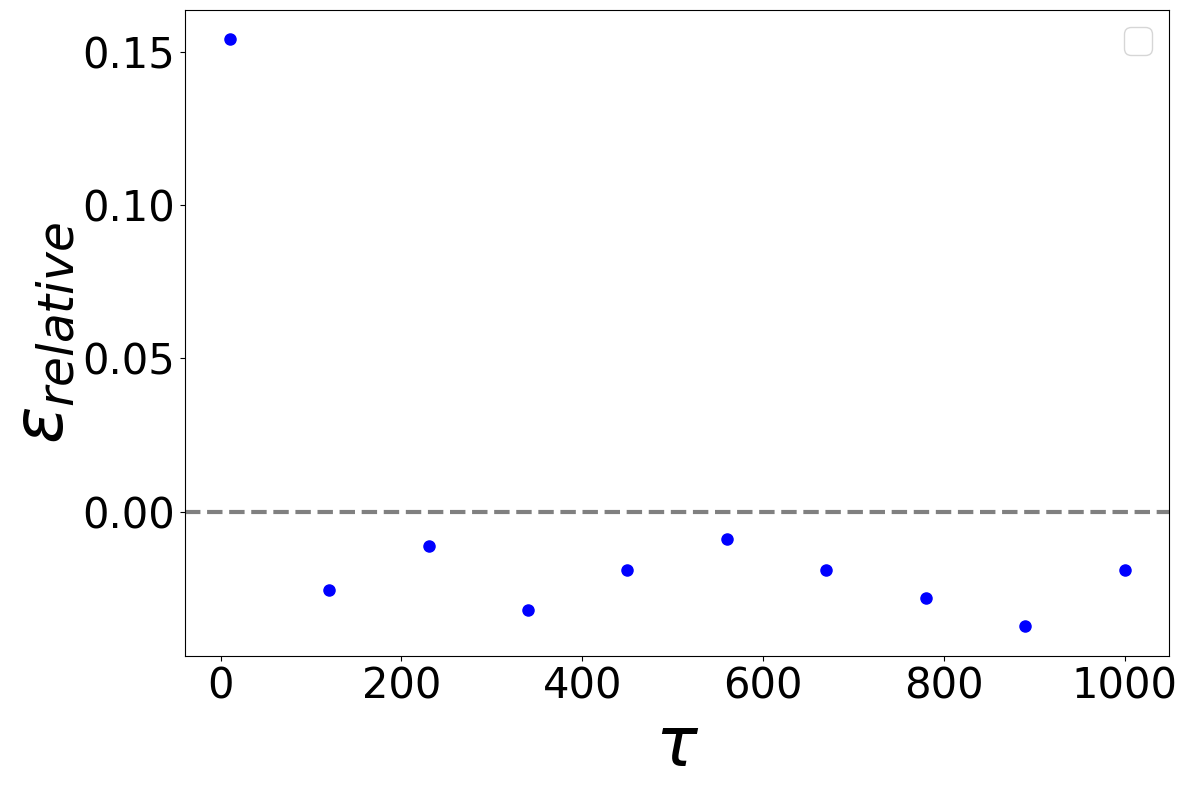

In [60]:
plot_function(tau_results, error_results, r"$\tau$", r"$\epsilon_{relative}$", titulo="tau-error.pdf")